In [91]:
import whisper
import clip
import torch
from PIL import Image
import numpy as np
import shutil
import ffmpeg
import natsort
from natsort import natsorted
import os
import subprocess
import face_recognition
import cv2
from collections import defaultdict
from io import BytesIO
import matplotlib.pyplot as plt
import whisperx
import pandas as pd

## WhisperX(Diarization with Transcription)

In [92]:
'''
Transcribe the video with diarization. Diarized segments assigns the id to speakers

Parameters:
video_path(str): path to the video source
hf_token(str): huggingface token to access diarization model (optional)

Returns:
result(dict): texts from the video source with time stamps
'''
def speech_diarization(video_path, hf_token=None):

     # transcribe
    model = whisper.load_model("base")
    result = model.transcribe(video_path, word_timestamps=True)
    
    # with diarization
    if hf_token:
        device = "cpu"
        batch_size = 16
        compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)

        diarize_model = whisperx.DiarizationPipeline(use_auth_token=hf_token, device=device)

        # add min/max number of speakers if known
        diarize_segments = diarize_model(video_path)
        # diarize_model(audio, min_speakers=min_speakers, max_speakers=max_speakers)
        result = whisperx.assign_word_speakers(diarize_segments, result)
        return result, diarize_segments # segments are now assigned speaker IDs
   
    return result

# CLIP

return the emotion based on a facial image

In [93]:
'''
return the emotion from the facial image

Parameters:
image(str): image of the face
emotions(list): list of emotion, default is 7 emotions

Returns:
emotion(str): the most likely emotion from the image

'''
def detect_emotions(image, emotions):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/16", device=device)

    image = preprocess(image).unsqueeze(0).to(device)
    text = clip.tokenize(emotions).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return emotions[np.argmax(probs)]

# Frame Extraction

extract the frame that has the most frequent face based on the time stamp of each sentences from the transcribed/diarized segment.


In [94]:
def find_most_frequent_face(frame_data, known_faces, face_frequency):
    SPEAKER_id = 1
    
    for frame in frame_data:
        image = Image.open(BytesIO(frame))
        np_unknown = np.array(image)
        unknown_encoding = face_recognition.face_encodings(np_unknown)

        if not unknown_encoding:
            continue
        
        # face recognition 
        results = face_recognition.compare_faces(list(known_faces.values()), unknown_encoding[0], tolerance=0.7)

        # known SPEAKER
        if True in results:
            id = list(known_faces.keys())[results.index(True)]
            face_frequency[id] += 1
        else: # unknown
            known_faces[SPEAKER_id] = unknown_encoding[0] 
            face_frequency[SPEAKER_id] = 1
            SPEAKER_id += 1
        
    most_frequent_face_index = max(face_frequency, key=face_frequency.get) if face_frequency else 2
    return frame_data[most_frequent_face_index]

In [95]:
def merge_diarized_transcripts(result, diarize_segments):
    """
    Merge diarized audio segments with transcribed text, aligning based on timestamps.

    Parameters:
    diarized_segments (DataFrame): Dataframe containing diarized segments with speaker information.
    transcription_result (dict): Dictionary containing transcribed text with word-level timestamps.

    Returns:
    list: List of tuples with format (start_time, end_time, speaker, transcribed_text)
    """

    merged_segments = []
    diarize_data = diarize_segments[['start', 'end', 'speaker']].to_numpy()

    # Iterate through each segment in transcription_result
    for segment in result['segments']:
        seg_start, seg_end = segment['start'], segment['end']
        seg_text = segment['text']
        seg_speaker = segment.get('speaker', 'Unknown')

        # Find the matching diarized segment based on time overlap
        for diarize_start, diarize_end, diarize_speaker in diarize_data:
            if seg_start <= diarize_end and seg_end >= diarize_start:
                # Check if the speaker matches, if not use the diarized speaker
                speaker = seg_speaker if seg_speaker != 'Unknown' else diarize_speaker

                # Create a tuple for the merged segment
                merged_segment = (max(seg_start, diarize_start), 
                                  min(seg_end, diarize_end), 
                                  speaker, seg_text)
                merged_segments.append(merged_segment)
                break

    return merged_segments


In [96]:
# with diarization
def extract_frame(video_path, result, diarize_segments, frame_output_path):
    merged_segments = merge_diarized_transcripts(result, diarize_segments)
    
    for i, segment in enumerate(merged_segments):
        start, end = segment[0], segment[1]
        interval = (end - start) / 6  # Dividing the interval into parts for 5 frames

        # generate 5 images of an interval
        frame_data = [] 
        known_faces = {}
        face_frequency = {}
        for j in range(1, 6):  # Looping for 5 frames
            frame_time = start + j * interval

            command = [
                'ffmpeg', '-y', 
                '-ss', str(frame_time),
                '-i', video_path, 
                '-frames:v', '1',
                '-f', 'image2pipe', 
                '-vcodec', 'mjpeg', 
                'pipe:1'
            ]
            process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            frame_data.append(process.stdout)  # Append the frame data to the list

        # find the most frequent face
        most_frequent_face_frame = find_most_frequent_face(frame_data, known_faces, face_frequency)

        # export the frame as an jpg
        filename = f"frame_{i}.jpg"
        file_path = os.path.join(frame_output_path, filename)

        with open(file_path, 'wb') as file:
            file.write(most_frequent_face_frame)

In [97]:
def extract_frame_vision_based(video_path, result, frame_output_path):

    for i in range(len(result['segments'])):
        
        start, end = result['segments'][i]['start'], result['segments'][i]['end']
        interval = (end - start) / 6  # Dividing the interval into parts for 5 frames

        # generate 5 images of an interval
        frame_data = [] 
        known_faces = {}
        face_frequency = {}
        for j in range(1, 6):  # Looping for 5 frames
            frame_time = start + j * interval

            command = [
                'ffmpeg', '-y', 
                '-ss', str(frame_time),
                '-i', video_path, 
                '-frames:v', '1',
                '-f', 'image2pipe', 
                '-vcodec', 'mjpeg', 
                'pipe:1'
            ]
            process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            frame_data.append(process.stdout)  # Append the frame data to the list

        # find the most frequent face
        most_frequent_face_frame = find_most_frequent_face(frame_data, known_faces, face_frequency)

        # export the frame as an jpg
        filename = f"frame_{i}.jpg"
        file_path = os.path.join(frame_output_path, filename)

        with open(file_path, 'wb') as file:
            file.write(most_frequent_face_frame)

## Audio Based Frame Extraction

In [98]:
def extract_frame_audio_based(frame_id, video_path, start, end):
    
    path_parts = video_path.split('/')
    frame_output_path = '/'.join(path_parts[:-1]) + '/frames/'
    os.makedirs(frame_output_path, exist_ok=True)

    interval = (end - start) / 6  # Dividing the interval into parts for 5 frames

    # generate 5 images of an interval
    frame_data = [] 
    known_faces = {}
    face_frequency = {}
    for j in range(1, 6):  # Looping for 5 frames
        frame_time = start + j * interval

        command = [
            'ffmpeg', '-y', 
            '-ss', str(frame_time),
            '-i', video_path, 
            '-frames:v', '1',
            '-f', 'image2pipe', 
            '-vcodec', 'mjpeg', 
            'pipe:1'
        ]
        process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        frame_data.append(process.stdout)  # Append the frame data to the list

    # find the most frequent face
    most_frequent_face_frame = find_most_frequent_face(frame_data, known_faces, face_frequency)

    # export the frame as an jpg
    filename = f"frame_{frame_id}.jpg"
    file_path = os.path.join(frame_output_path, filename)

    with open(file_path, 'wb') as file:
        file.write(most_frequent_face_frame)
    
    return file_path

# Face Detection

Store and retrieve the faces from the image. 

In [99]:
'''
Store and retrieve the faces from the image. 

Parameters:
img_path(str): path to the image 
SPEAKER(str): current speaker 
SPEAKER_id(int): id for the speaker to keep track of
emotions(list): all possible emotions 
known_faces(dict): faces that have appeared before:
emotion_scores(dict): the emotion of each characters as the dialogue progres

Returns:
Updated SPEAKER, SPEAKER_id, emotion, emotion_scores
'''

def face_detection(img_path, SPEAKER, SPEAKER_id, emotions, known_faces, emotion_scores):
    image = face_recognition.load_image_file(img_path)
    face_locations = face_recognition.face_locations(image)
    emotion = 'Neutral'

    # face detected
    if face_locations:
        largest_face = max(face_locations, key=lambda loc: (loc[2] - loc[0]) * (loc[1] - loc[3]))

        # process faces 
        top, right, bottom, left = largest_face
        face_image = image[top:bottom, left:right]
        pil_image = Image.fromarray(face_image)
        emotion = detect_emotions(pil_image, emotions)

        np_unknown = np.array(pil_image)
        unknown_encoding = face_recognition.face_encodings(np_unknown)

        # face can be encoded
        if unknown_encoding:
            results = face_recognition.compare_faces(list(known_faces.values()), unknown_encoding[0], tolerance=0.7)

            # Check if a SPEAKER is identified
            if True in results:
                SPEAKER = list(known_faces.keys())[results.index(True)]   
            else:
                known_faces[f'SPEAKER {SPEAKER_id}'] = unknown_encoding[0] # add new SPEAKER to known
                SPEAKER = f'SPEAKER {SPEAKER_id}'
                SPEAKER_id += 1
            
            # emotion scores
            emotion_scores.append({SPEAKER:emotion})
    
    return SPEAKER, SPEAKER_id, emotion, emotion_scores

# Data Extraction

Vision based: 
Frames are extracted prior to the assignement of speakers. Based on the transcribed/diarized audio time stamp to excerpt the frames thas has the most frequent faces with face detection. 

Audio based:
Frames are extracted based on the diarized segments. The assignment of speakers is from the diarized model. 

## Vision Based Data Extraction

In [100]:
def extract_data_vision(video_path, emotions_dict, hf_token, result, diarize_segments):
    path_parts = video_path.split('/')
    frame_output_path = '/'.join(path_parts[:-1]) + '/frames/'
    
    if os.path.exists(frame_output_path):
        shutil.rmtree(frame_output_path)
        
    os.makedirs(frame_output_path, exist_ok=True)
    extract_frame(video_path, result, diarize_segments, frame_output_path)

    dialogue = ""
    known_faces = {}
    SPEAKER_id = 1
    SPEAKER = 'SPEAKER 1'
    current_speaker = None
    emotions = list(emotions_dict.keys())
    emotion_scores = []
    files = natsorted(os.listdir(frame_output_path))
    
    # iterate through frames
    for i, file in enumerate(files):
        sentence = result['segments'][i]['text']
        img_path = os.path.join(frame_output_path, file)
        SPEAKER, SPEAKER_id, emotion, emotion_scores = face_detection(img_path, SPEAKER, SPEAKER_id, emotions, known_faces, emotion_scores)
                                 
        # speaker changed
        if current_speaker != SPEAKER:
            current_speaker = SPEAKER

            dialogue += f"\n{current_speaker}({emotion}):"
            print(f"\n{current_speaker}({emotion}):", end="")

        dialogue += sentence
        print(sentence, end="")        

    return dialogue, emotion_scores  

## Audio Based Data Extraction 

In [101]:
def extract_data_audio(video_path, emotions_dict, hf_token, result, diarize_segments):
    
    current_speaker = None
    dialogue = ""
    known_faces = {}
    SPEAKER_id = 1
    frame_id = 1
    emotions = list(emotions_dict.keys())
    emotion_scores = []

    for segment in result['segments']:
        text = segment['text']
        start = segment['start']
        end = segment['end'] 
        SPEAKER = segment.get('speaker', None)

        if current_speaker != SPEAKER:
            img_path = extract_frame_audio_based(frame_id, video_path, start, end)
            frame_id += 1
            _, SPEAKER_id, emotion, emotion_scores = face_detection(img_path, current_speaker, SPEAKER_id, emotions, known_faces, emotion_scores)
            print(f"\n{SPEAKER}({emotion}): ", end="")
            current_speaker = SPEAKER
            dialogue += f"\n{SPEAKER}({emotion}): "
        
        print(text, end="")
        dialogue += text

    return dialogue, emotion_scores

# Audio + Vision (havn't done yet)

In [102]:
def extract_audio_vision(video_path, emotions_dict, hf_token):
    current_spkear = None
    dialogue = ""
    known_faces = {}
    SPEAKER_id = 1
    frame_id = 1
    vision_current_speaker = None
    audio_current_speaker = None
    emotions = list(emotions_dict.keys())
    emotion_scores = []
    result, diarize_segments = speech_diarization(video_path, hf_token)

    for segment in result['segments']:
        text = segment['text']
        start = segment['start']
        end = segment['end'] 
        audio_SPEAKER = segment['speaker']

        # extract frame
        img_path = extract_frame_audio_based(frame_id, video_path, start, end)
        frame_id += 1
        vision_SPEAKER, SPEAKER_id, emotion, emotion_scores = face_detection(img_path, SPEAKER_id, emotions, known_faces, emotion_scores)

        if audio_current_speaker != audio_SPEAKER and vision_current_speaker != vision_SPEAKER: 
            if vision_SPEAKER is None:
                vision_SPEAKER = audio_SPEAKER 
            print(f"\n{vision_SPEAKER}({emotion}): ", end="")
            dialogue += f"\n{vision_SPEAKER}({emotion}):"

            audio_current_speaker = audio_SPEAKER
            vision_current_speaker = vision_SPEAKER
        
        print(text, end="")
        dialogue += text


# Test

In [114]:
# scores and emotions mapping
emotions_dict = {
    "Neutral": 0.5,
    "Happy": 1,
    "Sad": 0,
    "Surprised": 0.6,
    "Afraid": 0.1,
    "Disgusted": 0.2,
    "Angry": 0.1,
    "Contempt": 0.3
}

emotions = list(emotions_dict.keys())

### Brooklyn nine nine

In [105]:
# ideal output
'''
SPEAKER 1(Angry): You wanted to see me, sir?
SPEAKER 2(Neutral): We have a situation in his bag. Check your email. 
SPEAKER 1(Suprised): No. 
SPEAKER 2(Angry):Yes, Kevin insists on you and Marcus joining us for dinner at our house. 
SPEAKER 1(Angry): We agreed to keep our personal and professional lives separate. It is weird enough I am dating your nephew without dragging your husband and dog into it.
SPEAKER 2(Surprised): You think I want this because I do not want this? Sadly, Marcus and Kevin can be held off no longer.
SPEAKER 1(Angry): Okay. So what's our play here? My stomach is a little off. I could say I am sick.
SPEAKER 2(Angry): Well, I have used this sick excuse for you eight times. I think they are catching on.
SPEAKER 1(Angry): You could say you are sick.
SPEAKER 2(Surprised): No way would ever believe that. No. This is happening.
SPEAKER 1(Angry): But don't worry.
SPEAKER 2(Surprised): I have a plan to keep things from getting too personal. I am inviting some intimacy buffers.
SPEAKER 3(Surprised): Dinner party at your house? Oh mama!
SPEAKER 4(Surprised): I will be there. All I ask is that you clear the furniture out of your living room so I can show calves some of my new dance opera.
SPEAKER 1(Sad): Why just some of it? Do the whole thing. 
SPEAKER 2(Surprised): Yes, nothing would make me happier. See you Thursday at 8.
'''

"\nSPEAKER 1(Angry): You wanted to see me, sir?\nSPEAKER 2(Neutral): We have a situation in his bag. Check your email. \nSPEAKER 1(Suprised): No. \nSPEAKER 2(Angry):Yes, Kevin insists on you and Marcus joining us for dinner at our house. \nSPEAKER 1(Angry): We agreed to keep our personal and professional lives separate. It is weird enough I am dating your nephew without dragging your husband and dog into it.\nSPEAKER 2(Surprised): You think I want this because I do not want this? Sadly, Marcus and Kevin can be held off no longer.\nSPEAKER 1(Angry): Okay. So what's our play here? My stomach is a little off. I could say I am sick.\nSPEAKER 2(Angry): Well, I have used this sick excuse for you eight times. I think they are catching on.\nSPEAKER 1(Angry): You could say you are sick.\nSPEAKER 2(Surprised): No way would ever believe that. No. This is happening.\nSPEAKER 1(Angry): But don't worry.\nSPEAKER 2(Surprised): I have a plan to keep things from getting too personal. I am inviting some

In [106]:
# vision based test
video_path = 'tv clips/nine-nine/nine-nine.mp4'
# hugging face token
hf_token = '<>' 

result, diarize_segments = speech_diarization(video_path, hf_token)
dialogue, emotion_scores = extract_data_vision(video_path, emotions_dict, hf_token, result, diarize_segments)


SPEAKER 1(Contempt): You wanted to see me, sir? We have a situation in his bag. Check your email. No. Yes, Kevin insists on you and Marcus joining us for dinner at our house. We agreed to keep our personal and professional lives separate. It is weird enough I am dating your nephew without dragging your husband and dog into it.
SPEAKER 2(Surprised): You think I want this because I do not want this? Sadly, Marcus and Kevin can be held off no longer.
SPEAKER 1(Sad): Okay. So what's our play here? My stomach is a little off. I could say I am sick.
SPEAKER 2(Contempt): Well, I have used this sick excuse for you eight times. I think they are catching on.
SPEAKER 1(Contempt): You could say you are sick.
SPEAKER 2(Contempt): No way would ever believe that. No. This is happening.
SPEAKER 1(Contempt): But don't worry.
SPEAKER 2(Sad): I have a plan to keep things from getting too personal. I am inviting some intimacy buffers.
SPEAKER 3(Surprised): Dinner party at your house? Oh mama!
SPEAKER 1(C

In [107]:
# audio based
dialogue, emotion_scores = extract_data_audio(video_path, emotions_dict, hf_token, result, diarize_segments)


SPEAKER_01(Contempt):  You wanted to see me, sir?
SPEAKER_00(Neutral):  We have a situation in his bag. Check your email.
SPEAKER_01(Surprised):  No.
SPEAKER_00(Surprised):  Yes, Kevin insists on you and Marcus joining us for dinner at our house.
SPEAKER_01(Contempt):  We agreed to keep our personal and professional lives separate. It is weird enough I am dating your nephew without dragging your husband and dog into it.
SPEAKER_00(Surprised):  You think I want this because I do not want this? Sadly, Marcus and Kevin can be held off no longer.
SPEAKER_01(Contempt):  Okay. So what's our play here? My stomach is a little off. I could say I am sick.
SPEAKER_00(Contempt):  Well, I have used this sick excuse for you eight times. I think they are catching on.
SPEAKER_01(Contempt):  You could say you are sick.
SPEAKER_00(Contempt):  No way would ever believe that. No. This is happening. But don't worry. I have a plan to keep things from getting too personal. I am inviting some intimacy buffer

### The devil wears prada

In [108]:
# ideal output
'''
SPEAKER 1(Surprised): Who are you?
SPEAKER 2(Neutral): Uh, my name is Andy Sachs. I recently graduated from Northwestern University.
SPEAKER 1(Surprised): And what are you doing here?
SPEAKER 2(Surprised): Well, I think I could do a good job as your assistant. And, um... Yeah, I came to New York to be a journalist and sent letters out everywhere and then finally got a call from a wise clerk and met with Cherry up at human resources. And basically, it's this or auto universe. 
SPEAKER 1(Surprised): So you don't read runway?  And before today, you had never heard of me? 
No.
SPEAKER 2(Surprised): Uh, no.
SPEAKER 1(Angry): And you have no style or sense of fashion? 
SPEAKER 2(Sad): Well, um... I think that depends on what you're... 
SPEAKER 1(Angry): You know, that was a new question. Um... 
SPEAKER 2(neutral): I was editor in chief of the Daily Northwestern. I also, um, won a national competition for a college journalist with my series on the janitor's union, which explores the exploitation of... 
SPEAKER 1(Contempt): Thats all
SPEAKER 2(Surprised): Yeah, you know, okay. You're right. I don't fit in here. I am not skinny or glamorous and I don't know that much about fashion, but I'm smart. I learn fast and I will work very hard. 
SPEAKER 3(Surprised): All right, I got the exclusive on the Cavali for Guina. But the problem is with a huge feathered headdress, that she's wearing. She looks like she's working the mainstages, golden nugget. 
SPEAKER 2(Sad): Thank you for your time.
'''

"\nSPEAKER 1(Surprised): Who are you?\nSPEAKER 2(Neutral): Uh, my name is Andy Sachs. I recently graduated from Northwestern University.\nSPEAKER 1(Surprised): And what are you doing here?\nSPEAKER 2(Surprised): Well, I think I could do a good job as your assistant. And, um... Yeah, I came to New York to be a journalist and sent letters out everywhere and then finally got a call from a wise clerk and met with Cherry up at human resources. And basically, it's this or auto universe. \nSPEAKER 1(Surprised): So you don't read runway?  And before today, you had never heard of me? \nNo.\nSPEAKER 2(Surprised): Uh, no.\nSPEAKER 1(Angry): And you have no style or sense of fashion? \nSPEAKER 2(Sad): Well, um... I think that depends on what you're... \nSPEAKER 1(Angry): You know, that was a new question. Um... \nSPEAKER 2(neutral): I was editor in chief of the Daily Northwestern. I also, um, won a national competition for a college journalist with my series on the janitor's union, which explores 

In [109]:
# vision based
video_path = 'tv clips/the devil wears prada/prada devil.mp4'
result, diarize_segments = speech_diarization(video_path, hf_token)
dialogue, emotion_scores = extract_data_vision(video_path, emotions_dict, hf_token, result, diarize_segments)


SPEAKER 1(Contempt): Who are you?
SPEAKER 2(Angry): Uh, my name is Andy Sachs. I recently graduated from Northwestern University.
SPEAKER 1(Contempt): And what are you doing here?
SPEAKER 2(Surprised): Well, I think I could do a good job as your assistant. And, um... Yeah, I came to New York to be a journalist and sent letters out everywhere and then finally got a call from a wise clerk and met with Cherry up at human resources. And basically, it's this or auto universe. So you don't read runway? Uh, no. And before today, you had never heard of me?
SPEAKER 1(Contempt): No.
SPEAKER 2(Surprised): And you have no style or sense of fashion? Well, um... I think that depends on what you're... You know, that was a new question. Um... I was editor in chief of the Daily Northwestern. I also, um, won a national competition for a college journalist with my series on the janitor's union, which explores the exploitation of... Yeah, you know, okay.
SPEAKER 1(Contempt): You're right. I don't fit in 

In [110]:
# audio based
dialogue, emotion_scores = extract_data_audio(video_path, emotions_dict, hf_token, result, diarize_segments)


SPEAKER_03(Contempt):  Who are you?
SPEAKER_02(Angry):  Uh, my name is Andy Sachs. I recently graduated from Northwestern University.
SPEAKER_03(Contempt):  And what are you doing here?
SPEAKER_02(Happy):  Well, I think I could do a good job as your assistant.
None(Neutral):  And, um...
SPEAKER_02(Sad):  Yeah, I came to New York to be a journalist and sent letters out everywhere and then finally got a call from a wise clerk and met with Cherry up at human resources. And basically, it's this or auto universe. So you don't read runway?
SPEAKER_03(Surprised):  Uh, no. And before today, you had never heard of me? No. And you have no style or sense of fashion?
None(Happy):  Well, um...
SPEAKER_03(Sad):  I think that depends on what you're... You know, that was a new question.
None(Surprised):  Um...
SPEAKER_02(Sad):  I was editor in chief of the Daily Northwestern. I also, um, won a national competition for a college journalist with my series on the janitor's union, which explores the expl

issues:
1. Vision based works better at speaker speaker recognition but worse at assigning texts
2. Audio based can't detect speakers very well
3. Hard to detect the person talking when multiple people are in the same frame 



# Emotion Flow

In [128]:
def emotion_flow(emotion_scores, emotions_dict):
    # initialize scores
    SPEAKER_scores = {}
    index = 0
    for score_dict in emotion_scores:
        for SPEAKER, score in score_dict.items():
            if SPEAKER not in SPEAKER_scores:
                SPEAKER_scores[SPEAKER] = {}

            SPEAKER_scores[SPEAKER][index] = emotions_dict[score]
            index += 1

    for SPEAKER in SPEAKER_scores:
        indices_scores = SPEAKER_scores[SPEAKER]
        indices = list(indices_scores.keys())
        scores = list(indices_scores.values())
        plt.plot(indices, scores, label=SPEAKER, marker='o')

    plt.ylim(0, 1)
    plt.title('Emotion Flow')
    plt.xlabel('conersation')
    plt.ylabel('mood')

    plt.legend()
    plt.show()

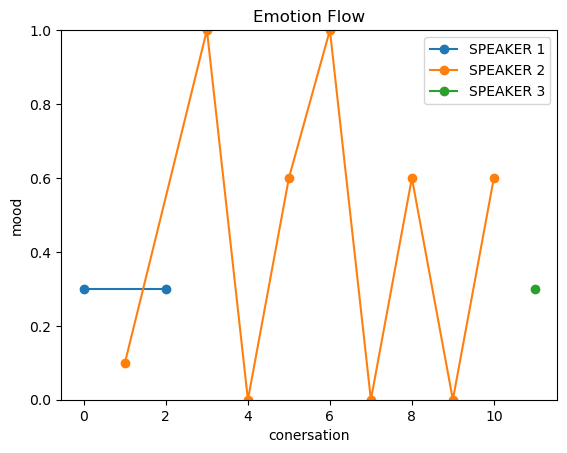

In [129]:
emotion_flow(emotion_scores, emotions_dict)

# GPT-4 QA

In [123]:
import openai
openai.api_key = '<api key>'
import pandas as pd
import json
import numpy as np
import time

In [124]:
def chat(input, model, prompt=None):
    message = [{"role": "system", "content": prompt},
              {"role": "user", "content": input}]
    completion = openai.ChatCompletion.create(model=model,messages=message)
    reply_content = completion.choices[0].message.content

    return reply_content

def QA(prompt, dialogue, question):
    data = {}
    input = f"{dialogue} Answer this question: {question}"

    data['text'] = prompt
    data['question'] = input
    answer = chat(input, 'gpt-4', prompt)
    
    return answer, data

In [1]:
question_1 = "What is the social relation between SPEAKER 1 and SPEAKER 2?"
question_2 = "Why does SPEAKER 1 want to invite SPEAKER 3 and SPEAKER 4?"
question_3 = "What would you guess how does SPEAKER 3 feels about SPEAKER 1"
question_4 = "Based on this interaction, analyze the personality of each SPEAKER"

In [ ]:
prompt = "Read the following context: "
question = question_4

answer, data = QA(prompt, dialogue, question)
print(data)